## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os
from ttictoc import TicToc

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
import hickle as hkl

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
#sys.path.insert(0,'../py-MDNet/modules')
#from sample_generator import *

### Initialize hyper-parameters

In [5]:
learning_rate = 1e-4
batch_size = 500
replay_memory_size = 4000
#epsilon = 0.1
gamma = 0.95

resume = False # resume from previous checkpoint?
render = False
eps = np.finfo(np.float32).eps.item()


In [6]:
# load dataset
db_no = 4
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 49)
Total number of person in data set:  (1, 49)


In [7]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 200
input_size = h_len*(num_camera) + num_camera+4+1

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

### Model

In [8]:
# Initialize required parameters
hidden_size1 = 4096+2048
hidden_size2 = 2048+1024
hidden_size3 = 256+256

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        #self.fch4 = nn.Linear(hidden_size3, hidden_size4)
        self.fco = nn.Linear(hidden_size3, num_camera)
        self.dropout = nn.Dropout(p=0.3)
        
        # Activation function 
        #self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.dropout(x)
        x = self.relu(self.fch3(x))
        x = self.dropout(x)
        #x = self.relu(self.fch4(x))
        #x = self.dropout(x)
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [9]:
# build the model
if use_cuda:
    policy_net = NextCamera().cuda()
    policy_net.float().cuda()
    criterion = nn.MSELoss().cuda()
else:
    policy_net = NextCamera()
    policy_net.float()
    criterion = nn.MSELoss()
# use ADAM as optimizer since we can load the whole data to train
#cls_weights = [1.0,1.0,1.0,1.0,0.1 ]
#cls_weights = torch.FloatTensor(cls_weights).cuda()
#criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [10]:
def backward_network(replay_memory):
    # sample random minibatch
    minibatch = random.sample(replay_memory, min(len(replay_memory), batch_size))
    
    # unpack minibatch
    state = torch.cat(tuple(d[0] for d in minibatch))
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    nSteps_boot = tuple(d[4] for d in minibatch)
    
    #print (state.size(), next_state.size(), reward.size(), action.size())

    if use_cuda:  # put on GPU if CUDA is available
        state = state.cuda()
        action = action.cuda()
        reward = reward.cuda()
        next_state = next_state.cuda()

    # get output for the next state
    next_output = policy_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4]
                              else reward[i] + (gamma**(nSteps_boot[i])) * torch.max(next_output[i])
                              for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()
    
    return loss.data


### Testing functions

In [11]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0.1
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        occ_len = 0.0001
        # Make initial state
        _,state,rt = make_state_vector(ped, curr_camera,curr_frame, ch,occ_len)
        #print (state.size())
        num_steps = 0
        #prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())


        while(curr_frame <= ped[-1,1]): # alltime-6):
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            if req_inc:
                if inc==1 and y!=num_camera-1:
                     # inside a camera
                    accP.append((y,y))
                elif inc==0 and y==c.item(0) and y!=num_camera-1:
                    # transitioning to second camera
                    accP.append((y,c.item(0)))
                    inc = 1
                elif inc==1 and y==num_camera-1:
                    # moving out of a camera FOV
                    inc = 0
                    accP.append((y,c.item(0)))
                else:
                    # Making transition
                    accP.append((y,c.item(0)))
                    #print ('Another case',y,c.item(0))
                    
            else:
                    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                curr_camera = c
                
                ispresent = 1
                
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += fpsc
            if occ_len > occ_max_val:
                occ_len = occ_max_val+1
                
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            hcount = occ_len #np.array(np.log(occ_len))
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
                
            if isdebug:
                print ('x_t: ', curr_camera,rt)
                print ( np.where(ch))
                print ('Q values: ', value_c)
                print (c, curr_frame, hcount)
                print ('isPresent', ispresent)
                print ('')
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))
            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get next state
            #next_state,reward,y,ispresent = get_next_step(ped,c,curr_frame, state)
            
            # store current reward
            reward_sum += reward
                        
            state = next_state
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        
    return rsT, accT

### Run episodes

In [12]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory = []
M = np.zeros((num_camera,num_camera))

In [13]:
# Load model if required
resume = False
backup_fname = './models/Q_db4_xywh_10log'
if resume:
    policy_net = torch.load(backup_fname)
    policy_net.eval()
    print ('Model loaded')
    #episode_reward,running_reward = hkl.load(backup_fname+'_variables.hkl')
    print ('episodic reward loaded')

In [14]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    #print (img.size)
    #hc = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
    #hc = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
    hc = occ_len #np.array(np.log(occ_len))
    
    if p:
        ## Draw samples
        #examples = gen_samples(SampleGenerator('gaussian', img.size, 0.1, 1.2),
        #                       bbox, numSamples, overlap_thres)  # 50 samples with 0.8 overlap
        ##print (examples.shape)
        #samples = examples[np.random.randint(len(examples))].reshape(1,4)
        ##print (samples)
        ##rt = afc.find_curr_rt(samples[0])
        #bbox = samples[0]
        rt = np.zeros((4))
        rt[0] = bbox[0]/imw
        rt[1] = bbox[1]/imh
        rt[2] = bbox[2]/imw
        rt[3] = bbox[3]/imh
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        this_cam = np.zeros((num_camera+1))
        this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
        this_cam[num_camera] = hc
        state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc)) #.ravel()))
        state = np.concatenate((state, ch.ravel()))
        state = state.reshape(1,-1)
        
        if use_cuda:
            state = torch.from_numpy(state).float().cuda()
        else:
            state = torch.from_numpy(state).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        state = []
    
    return p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs


In [15]:
epoch = 0
occ_max_val = 50
NBoot = 20
t = TicToc('episodic')
t.tic()

In [19]:
policy_net.train()
max_ep_len = 200

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
     
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < 2*max_ep_len:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2: # and np.random.rand() < 0.9:
            continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        #tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        #startIDX = np.random.choice(tranIDX) if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len )
        startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam)]
        print ('startIDX: ',startIDX)
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        tmp_ep = []
        rs = []
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.0001
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        _,state,rt=make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        stCam = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
                       
        while(curr_frame <= ped[-1,1]):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            
            # epsilon annealing
            epsilon = 1 / np.log(epoch + 0.0000001)
                 
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                            if random_action
                            else torch.argmax(value_c)][0]

            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy()
            
            # generate random steps
            if np.random.rand(1) < 0.2:
                rsteps = np.random.randint(5)
            else:
                rsteps = fpsc
            
            # find target for the next frame
            curr_frame += rsteps #fpsc
            num_steps += 1
            M[stCam,c] += 1
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                #print (rt, np.where(rt))
                curr_camera = c
                #ch = np.zeros((h_len,num_camera))
                #num_steps = 0
                ispresent = 1
                stCam = c
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += rsteps
            if occ_len > occ_max_val:
                occ_len = occ_max_val+1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = occ_len #np.array(np.log(occ_len))
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))

            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            if y == num_camera-1 and y == c:
                reward = 0.1
            elif y == c:
                reward = 1
            else:
                reward = -1
                 
            if np.random.rand() < 0.2 and epoch > 500:
                print (epoch, p, random_action, rsteps)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch))
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
            reward_sum += reward
            rs.append(reward)
                
            # save transition to replay memory
            tmp_ep.append((state, one_hot_action, reward, next_state, ispresent))
            
            state = next_state
            
            if num_steps >= max_ep_len and c!=num_camera-1 and y == c:  # break the episode
                #replay_memory.append((state, one_hot_action, reward, next_state, ispresent))
                print (epoch, p, random_action)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch)[1])
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
                # Append to the experience buffer
                for tmp_i in range(0,len(tmp_ep)):
                    this_tmp = tmp_ep[tmp_i]
                    # compute n-step return
                    rew = 0
                    for ni in range(NBoot):
                        if (tmp_i+ni) < len(tmp_ep):
                            rew += rs[tmp_i+ni]*(gamma**ni)
                    if use_cuda:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0).cuda()
                    else:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0)
                    # get the next state
                    next_state = tmp_ep[np.min([tmp_i+NBoot-1,len(tmp_ep)-1])]
                    next_state = next_state[3]
                    
                    replay_memory.append((this_tmp[0],this_tmp[1],reward,next_state,np.min([NBoot,len(tmp_ep)-tmp_i])))
                    if len(replay_memory) > replay_memory_size:
                        replay_memory.pop(0)
                tmp_ep = []
                break
        
        # update value_function
        if len(replay_memory) > 0:
            loss = backward_network(replay_memory)
        
        # store episodic reward
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        if epoch % 2 == 0:
            print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        #if epoch % 1000 == 1: 
        #    torch.save(policy_net, backup_fname)
        #    #hkl.dump([[episode_reward,validation_reward, running_reward]], backup_fname+'_variables.hkl')
            
        reward_sum = 0
        num_steps = 0
        rs = []
        
    #print (M)
    epoch += 1
    if epoch % 10 == 0:
        t.toc()
        print('Time elapsed: ', t.elapsed)
        

startIDX:  1413
1111 0 False 1
x_t:  3 [0.4375     0.3        0.1        0.34583333]
Q values:  tensor([[3.5345, 4.3643, 4.1254, 6.1037, 3.9695, 2.9076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 15251 3 0.0001
isPresent 1

1111 0 False 2
x_t:  3 [0.475      0.2875     0.103125   0.36666667]
Q values:  tensor([[3.1821, 3.8578, 4.9484, 6.2487, 3.7394, 2.2121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 15255 5 0.0001
isPresent 1

1111 0 False 2
x_t:  3 [0.4875     0.3        0.11875    0.37083333]
Q values:  tensor([[1.8992, 2.6415, 4.9116, 6.1752, 3.8076, 2.5078]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 15257 6 0.0001
isPresent 1

1111 0 True 2
x_t:  3 [0.4875     0.3125     0.13125    0.35416667]
Q values:  tensor([[4.5338, 4.0793, 4.1983, 6.4546, 4.5000, 3.4729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 15259 7 0.0001
isPresent 1

1111 0 True 2
x_t:  3 [0.5625     0.30833333 0.121875   0.38333333]
Q values:  tensor([[4.4888, 4.4598, 5

Q values:  tensor([[-1.6650, -1.5221, -1.6470, -1.5322, -1.5638, -0.6269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 15609 186 51
isPresent 0

1111 0 False 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-1.4217, -1.4510, -1.5537, -1.3507, -1.6259, -0.6029]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 15623 193 51
isPresent 0

1111 0 False 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-1.4301, -1.5295, -1.4110, -1.4458, -1.4966, -0.5877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 15627 195 51
isPresent 0

1111 0 False 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-1.7069, -1.7430, -1.8822, -1.4899, -1.6478, -0.8061]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 15637 200 51
isPresent 0

1111 0 True 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-1.8616, -2.3154, -1.9341, -1.8625, -2.0476, -0.9652]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 0 15653 20

Q values:  tensor([[-2.8921, -3.1583, -2.5605, -2.8654, -2.7833, -1.5071]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 16111 436 51
isPresent 0

1111 0 True 3
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-1.9325, -1.5367, -1.3680, -1.5479, -1.3147, -0.8390]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 16142 454 51
isPresent 0

1111 0 False 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-1.9461, -2.2698, -2.0495, -1.6377, -2.1942, -1.0513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 16146 456 51
isPresent 0

1111 0 False 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-2.4653, -2.1056, -2.6565, -1.9044, -2.1734, -1.1061]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 16160 463 51
isPresent 0

1111 0 False 2
x_t:  3 [0.915625 0.3375   0.078125 0.4375  ]
Q values:  tensor([[-2.6561, -2.5858, -2.6835, -2.5301, -2.7632, -1.3761]],
       device='cuda:0', grad_fn=<AddmmBackward>)
5 5 16167 46

KeyboardInterrupt: 

In [36]:
nSteps_boot = tuple(d[4] for d in replay_memory)
print ((nSteps_boot[10]))

20


In [ ]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 261, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.plot(yhat)


In [ ]:
# reward received during training
vpR = np.vstack(validation_reward)
plt.plot(vpR)

Initial position:  [    4 25224    92    91    22    71]
Initial position:  [  0 955 225  92  44  85]
Initial position:  [    2 23684   215    92    24    73]
Initial position:  [   3 2899   23   59   30   72]
Initial position:  [  3  25 231  76  34 100]
Initial position:  [    4 32615   149    71    10    29]
Initial position:  [   3 1365  207   77   34  113]
Initial position:  [    4 27660   232    93    34    69]
Initial position:  [    3 18808   164    77    61   114]
Initial position:  [   4 8496  139   74   25   50]
Initial position:  [    2 23134   190    97    41   115]
Initial position:  [   1 8903  200   78   55  111]
Initial position:  [   4 6802  244   83   33   73]
Initial position:  [   4 8320  125   70   20   48]
Initial position:  [   0 3868  231  100   25   86]
Initial position:  [    0 13845   250    95    19    52]
Initial position:  [    4 12847   107    87    24    69]
Initial position:  [    4 20597   144    68    12    35]
Initial position:  [    4 34388    50   

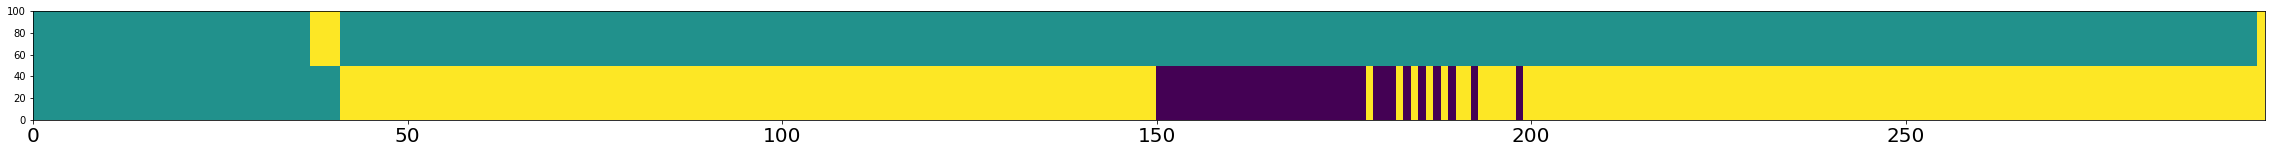

A,P,R:  0.12751677852348994 0.47435897435897434 0.12627986348122866
Num frames:  (78, 4)
Accuracy:  0.12751677852348994
Person:  1


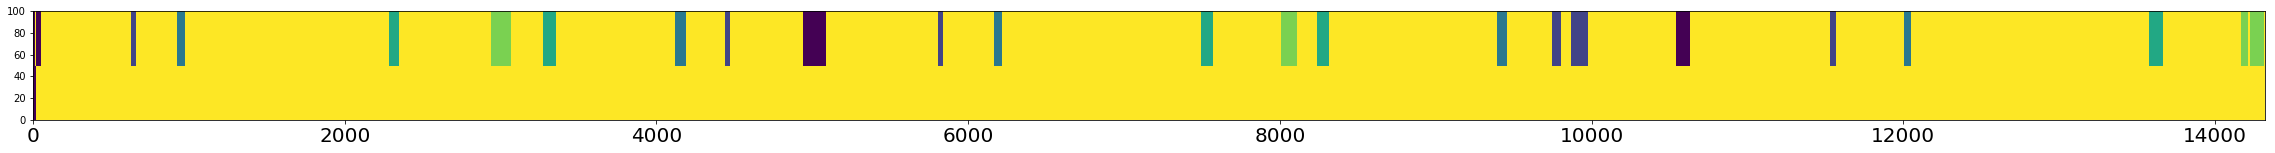

A,P,R:  0.886739752810558 0.8095238095238095 0.010397553516819572
Num frames:  (21, 4)
Accuracy:  0.886739752810558
Person:  2


KeyboardInterrupt: 

In [18]:
policy_net.eval()
req_inc = 0
_,acc = test_func(pTest,iloc='fix',eloc='last', fixLoc=25, isdebug=0, req_inc=req_inc)
tr_acc = 0
A,P,R,F, ttr = [],[],[],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [ ]:
tr_acc = 0
for i in range(5):
    print ('Person: ',i)
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    print (g)
    print (p)
    tr_acc += np.sum(g==p, dtype=np.float)/g.shape[0]
tr_acc/5

In [ ]:
np.log10(1000)

In [ ]:
mcta = []
nfr = []
for i in range(5):
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    mcta.append(afc.compute_MCTA(p,g))
    nfr.append(afc.compute_num_frames(p,g))
print (np.mean(mcta))
print (np.sum(nfr))

### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [ ]:
import numpy as np
1/np.log(10)

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])